# Initializing environment

In [1]:
import numpy as np
import os

# To make the output stable across other runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_farmer_income_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Loading dataset

In [2]:
import pandas as pd
train_df = pd.read_excel('Pearl Challenge data with dictionary.xlsx', sheet_name='TrainData')
test_df = pd.read_excel('Pearl Challenge data with dictionary.xlsx', sheet_name='TestData')

# Feature Engineering

In [12]:
drop_cols = ['FarmerID', 'Zipcode', 'CITY', 'DISTRICT', 'VILLAGE', 'Location']
target = 'Target_Variable/Total Income'
X = train_df.drop(columns=[target] + drop_cols)
y = np.log1p(train_df[target])

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

## Preprocessing data

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline model

In [15]:
import lightgbm as lgb

X_all_processed = preprocessor.fit_transform(X, y)
baseline_model = lgb.LGBMRegressor(n_estimators=200, random_state=42)
baseline_model.fit(X_all_processed, y)

LGBMRegressor(n_estimators=200, random_state=42)

In [16]:
ohe_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
feature_names = num_cols + list(ohe_features)

importances = pd.DataFrame({
    'feature': feature_names,
    'importance': baseline_model.feature_importances_
}).sort_values(by='importance', ascending=False)

In [17]:
from sklearn.feature_selection import SelectFromModel

# Add feature selector after preprocessing
feature_selector = SelectFromModel(
    estimator=lgb.LGBMRegressor(n_estimators=200, random_state=42),
    max_features=30,
    threshold=-np.inf,  # force top-N
    prefit=False
)


# Bayesian Hyperparametric Optimization function

In [20]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from lightgbm import early_stopping

pipeline = Pipeline([
    ("preprocessor", preprocessor)
])

# Step 1: Define objective
def objective(trial):
    # Step 2: Suggest hyperparameters
    param = {
        'objective': 'regression',
        'metric': 'mape',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'n_estimators': 1000,
        'verbosity': -1,
    }

    # Step 3: Train-validation split
    X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 4: Preprocess the data
    X_train_processed = pipeline.fit_transform(X_train_sub)
    X_valid_processed = pipeline.transform(X_valid_sub)

    # Step 5: Train LightGBM
    model = lgb.LGBMRegressor(**param)
    model.fit(
        X_train_processed, y_train_sub,
        eval_set=[(X_valid_processed, y_valid_sub)],
        eval_metric='mape',
        callbacks=[early_stopping(stopping_rounds=50)],
    )

    # Step 6: Evaluate
    preds = model.predict(X_valid_processed)
    mape = mean_absolute_percentage_error(np.expm1(y_valid_sub), np.expm1(preds))
    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  

print(f"Validation MAPE: {study.best_value*100:.2f} %")
print("Best Hyperparameters:", study.best_params)

[I 2025-08-17 15:05:04,724] A new study created in memory with name: no-name-1a50d13b-1fc9-485b-aa0f-ac569c85e610
C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:05:09,202] Trial 0 finished with value: 0.9999761827305216 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.03998716535230667, 'num_leaves': 93, 'max_depth': 18, 'min_child_samples': 77, 'colsample_bytree': 0.786398247840588, 'reg_alpha': 9.80763557432425, 'reg_lambda': 5.1462649092856125}. Best is trial 0 with value: 0.9999761827305216.
C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Pyt

Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:05:16,032] Trial 2 finished with value: 0.20969703150181443 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.05048519482510429, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 48, 'colsample_bytree': 0.5825253715349007, 'reg_alpha': 1.454422076220241, 'reg_lambda': 0.6948329075634452}. Best is trial 2 with value: 0.20969703150181443.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0147287
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:05:19,494] Trial 3 finished with value: 0.2110678100932442 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.06115208711382097, 'num_leaves': 47, 'max_depth': 7, 'min_child_samples': 14, 'colsample_bytree': 0.41284870797547657, 'reg_alpha': 8.947563710001512, 'reg_lambda': 0.055226737174763896}. Best is trial 2 with value: 0.20969703150181443.


Early stopping, best iteration is:
[836]	valid_0's mape: 0.0148643


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:05:23,679] Trial 4 finished with value: 0.9999997462663847 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.2580608704798489, 'num_leaves': 71, 'max_depth': 18, 'min_child_samples': 78, 'colsample_bytree': 0.846554020526247, 'reg_alpha': 0.7800730827310676, 'reg_lambda': 5.434725040107415}. Best is trial 2 with value: 0.20969703150181443.


Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:05:28,080] Trial 5 finished with value: 0.27887974645153907 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0013445391647192828, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 20, 'colsample_bytree': 0.4925714396529452, 'reg_alpha': 7.740224657002593, 'reg_lambda': 0.2826250349892345}. Best is trial 2 with value: 0.20969703150181443.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0199213
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:05:31,029] Trial 6 finished with value: 0.2180144248149152 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.048226049639292924, 'num_leaves': 18, 'max_depth': 10, 'min_child_samples': 81, 'colsample_bytree': 0.5980239390009227, 'reg_alpha': 7.794106579638691, 'reg_lambda': 6.057573046186366}. Best is trial 2 with value: 0.20969703150181443.


Did not meet early stopping. Best iteration is:
[998]	valid_0's mape: 0.0154063


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:05:39,491] Trial 7 finished with value: 1.0000009961744467 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.02814599327967853, 'num_leaves': 29, 'max_depth': 6, 'min_child_samples': 81, 'colsample_bytree': 0.9670556795848592, 'reg_alpha': 6.946997839011399, 'reg_lambda': 4.429705425564988}. Best is trial 2 with value: 0.20969703150181443.
C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _l

Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:05:54,392] Trial 10 finished with value: 0.22120470254554356 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.006585174830864521, 'num_leaves': 42, 'max_depth': 14, 'min_child_samples': 45, 'colsample_bytree': 0.6663698312183073, 'reg_alpha': 0.14374699812136882, 'reg_lambda': 9.331875819414112}. Best is trial 2 with value: 0.20969703150181443.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0156785
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:05:58,992] Trial 11 finished with value: 0.2183377687360723 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.010295670164988177, 'num_leaves': 43, 'max_depth': 11, 'min_child_samples': 13, 'colsample_bytree': 0.4435487225172514, 'reg_alpha': 4.149646818622177, 'reg_lambda': 0.1343151284305839}. Best is trial 2 with value: 0.20969703150181443.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0154739
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:06:01,529] Trial 12 finished with value: 0.21963886721580966 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.09181761989483914, 'num_leaves': 10, 'max_depth': 14, 'min_child_samples': 28, 'colsample_bytree': 0.54507097985035, 'reg_alpha': 9.718573549288523, 'reg_lambda': 2.2013732665878294}. Best is trial 2 with value: 0.20969703150181443.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0155018
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:06:05,944] Trial 13 finished with value: 0.2165189189630395 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.013621127737618284, 'num_leaves': 42, 'max_depth': 9, 'min_child_samples': 59, 'colsample_bytree': 0.4023421987706632, 'reg_alpha': 1.885832927117171, 'reg_lambda': 8.07506772301306}. Best is trial 2 with value: 0.20969703150181443.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.015328
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:06:08,329] Trial 14 finished with value: 0.2687875133122952 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0034747572887057045, 'num_leaves': 32, 'max_depth': 3, 'min_child_samples': 5, 'colsample_bytree': 0.663693312237672, 'reg_alpha': 5.71765664979252, 'reg_lambda': 1.7508648247588348}. Best is trial 2 with value: 0.20969703150181443.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0191338
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:06:12,075] Trial 15 finished with value: 0.20938990659588755 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.08241219219963317, 'num_leaves': 99, 'max_depth': 14, 'min_child_samples': 97, 'colsample_bytree': 0.5772691805472999, 'reg_alpha': 4.427257987838814, 'reg_lambda': 3.2837697994241566}. Best is trial 15 with value: 0.20938990659588755.


Early stopping, best iteration is:
[471]	valid_0's mape: 0.0146654
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[827]	valid_0's mape: 0.0146323


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:06:18,172] Trial 16 finished with value: 0.20818912479022988 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.030142758129888658, 'num_leaves': 98, 'max_depth': 14, 'min_child_samples': 100, 'colsample_bytree': 0.5851900652023333, 'reg_alpha': 4.3797005541244225, 'reg_lambda': 3.122990713155004}. Best is trial 16 with value: 0.20818912479022988.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's mape: 0.0146093


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:06:25,365] Trial 17 finished with value: 0.20783413721840632 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.02089004161680419, 'num_leaves': 99, 'max_depth': 15, 'min_child_samples': 100, 'colsample_bytree': 0.7444506911284533, 'reg_alpha': 4.41031538827445, 'reg_lambda': 3.2353358483919177}. Best is trial 17 with value: 0.20783413721840632.


Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:06:32,127] Trial 18 finished with value: 0.20786874702041946 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01990686139911026, 'num_leaves': 85, 'max_depth': 16, 'min_child_samples': 99, 'colsample_bytree': 0.7451585459951388, 'reg_alpha': 3.425462972546443, 'reg_lambda': 6.775072289393824}. Best is trial 17 with value: 0.20783413721840632.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0146129
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:06:40,174] Trial 19 finished with value: 0.21709808973902991 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0049301748928738875, 'num_leaves': 85, 'max_depth': 20, 'min_child_samples': 91, 'colsample_bytree': 0.7412592228986772, 'reg_alpha': 3.356731832570864, 'reg_lambda': 6.851426036911839}. Best is trial 17 with value: 0.20783413721840632.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0153927
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:06:46,869] Trial 20 finished with value: 0.2090178383899781 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.020284786866620084, 'num_leaves': 83, 'max_depth': 16, 'min_child_samples': 69, 'colsample_bytree': 0.7324943188074371, 'reg_alpha': 5.4640206577845145, 'reg_lambda': 7.116658136411758}. Best is trial 17 with value: 0.20783413721840632.


Did not meet early stopping. Best iteration is:
[999]	valid_0's mape: 0.0147068
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:06:53,188] Trial 21 finished with value: 0.2078800026730446 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.022980646262673085, 'num_leaves': 89, 'max_depth': 16, 'min_child_samples': 99, 'colsample_bytree': 0.6463814716427371, 'reg_alpha': 4.395772130222176, 'reg_lambda': 3.484500588485109}. Best is trial 17 with value: 0.20783413721840632.


Did not meet early stopping. Best iteration is:
[999]	valid_0's mape: 0.0146171
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:07:00,940] Trial 22 finished with value: 0.20824308518216722 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.015844776395651614, 'num_leaves': 86, 'max_depth': 16, 'min_child_samples': 90, 'colsample_bytree': 0.6756569565938668, 'reg_alpha': 3.093299394959273, 'reg_lambda': 3.9841525185334623}. Best is trial 17 with value: 0.20783413721840632.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0146604
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:07:08,512] Trial 23 finished with value: 0.21363488540367528 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.00775875248000944, 'num_leaves': 78, 'max_depth': 16, 'min_child_samples': 91, 'colsample_bytree': 0.7835449514672154, 'reg_alpha': 4.806752194113131, 'reg_lambda': 6.112912359666768}. Best is trial 17 with value: 0.20783413721840632.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0151023
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:07:15,283] Trial 24 finished with value: 0.20885872263667213 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.02240732573897892, 'num_leaves': 92, 'max_depth': 19, 'min_child_samples': 97, 'colsample_bytree': 0.7158380638589152, 'reg_alpha': 6.511286702776976, 'reg_lambda': 8.457029781738125}. Best is trial 17 with value: 0.20783413721840632.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0146987
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:07:22,842] Trial 25 finished with value: 0.23251908321570125 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.002502902302913009, 'num_leaves': 74, 'max_depth': 12, 'min_child_samples': 71, 'colsample_bytree': 0.7835189666374743, 'reg_alpha': 2.4401910383777023, 'reg_lambda': 4.625473033301028}. Best is trial 17 with value: 0.20783413721840632.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.016539
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:07:31,276] Trial 26 finished with value: 0.21007475317261534 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.010549552970762422, 'num_leaves': 90, 'max_depth': 17, 'min_child_samples': 89, 'colsample_bytree': 0.6312561093210652, 'reg_alpha': 3.8514769894229417, 'reg_lambda': 3.542209423861717}. Best is trial 17 with value: 0.20783413721840632.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0148256
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's mape: 0.0146914


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:07:39,178] Trial 27 finished with value: 0.20877955072324314 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.016500403623687206, 'num_leaves': 100, 'max_depth': 13, 'min_child_samples': 98, 'colsample_bytree': 0.7539278979121181, 'reg_alpha': 5.103583939472597, 'reg_lambda': 2.1623752077237035}. Best is trial 17 with value: 0.20783413721840632.


Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:07:49,192] Trial 28 finished with value: 0.2128857847901769 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.010180331769653711, 'num_leaves': 79, 'max_depth': 15, 'min_child_samples': 87, 'colsample_bytree': 0.9999101403352816, 'reg_alpha': 3.548403661087362, 'reg_lambda': 7.351957990234578}. Best is trial 17 with value: 0.20783413721840632.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0149995


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:07:55,620] Trial 29 finished with value: 1.0000010789293547 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.034458641725102934, 'num_leaves': 92, 'max_depth': 18, 'min_child_samples': 69, 'colsample_bytree': 0.8222897529061399, 'reg_alpha': 2.1488515695161015, 'reg_lambda': 5.3299564144928055}. Best is trial 17 with value: 0.20783413721840632.


Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:08:01,027] Trial 30 finished with value: 0.2105089064977979 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.023024376410165973, 'num_leaves': 66, 'max_depth': 20, 'min_child_samples': 73, 'colsample_bytree': 0.5383624396001792, 'reg_alpha': 6.418321567505785, 'reg_lambda': 5.9414950041481855}. Best is trial 17 with value: 0.20783413721840632.


Did not meet early stopping. Best iteration is:
[998]	valid_0's mape: 0.0148295
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:08:13,869] Trial 31 finished with value: 0.20805340346657247 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.03390883162004224, 'num_leaves': 96, 'max_depth': 13, 'min_child_samples': 100, 'colsample_bytree': 0.6225726260471338, 'reg_alpha': 4.583891693230523, 'reg_lambda': 3.192469746153815}. Best is trial 17 with value: 0.20783413721840632.


Did not meet early stopping. Best iteration is:
[999]	valid_0's mape: 0.0146185
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:08:20,119] Trial 32 finished with value: 0.2083159210615374 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.03429146089101938, 'num_leaves': 94, 'max_depth': 12, 'min_child_samples': 100, 'colsample_bytree': 0.6387532348932915, 'reg_alpha': 4.928732868510403, 'reg_lambda': 2.345273291161981}. Best is trial 17 with value: 0.20783413721840632.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0146118
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:08:24,683] Trial 33 finished with value: 0.2080508743728448 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.07568766760348461, 'num_leaves': 87, 'max_depth': 17, 'min_child_samples': 94, 'colsample_bytree': 0.7098701963592342, 'reg_alpha': 4.009971416179697, 'reg_lambda': 2.685592594381228}. Best is trial 17 with value: 0.20783413721840632.


Early stopping, best iteration is:
[587]	valid_0's mape: 0.0145913
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:08:29,829] Trial 34 finished with value: 0.20812397889285217 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.07543534859966093, 'num_leaves': 80, 'max_depth': 17, 'min_child_samples': 93, 'colsample_bytree': 0.6997684842102445, 'reg_alpha': 2.9451907765233027, 'reg_lambda': 1.3712881758231568}. Best is trial 17 with value: 0.20783413721840632.


Early stopping, best iteration is:
[705]	valid_0's mape: 0.014565


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:08:34,471] Trial 35 finished with value: 1.0000009864292014 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.13245585272563595, 'num_leaves': 89, 'max_depth': 17, 'min_child_samples': 85, 'colsample_bytree': 0.6996541803914383, 'reg_alpha': 1.5084337243138415, 'reg_lambda': 4.843374975095944}. Best is trial 17 with value: 0.20783413721840632.


Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:08:36,893] Trial 36 finished with value: 0.2128772159282593 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.2384610106976992, 'num_leaves': 74, 'max_depth': 19, 'min_child_samples': 76, 'colsample_bytree': 0.7687893697320453, 'reg_alpha': 3.8460651242739248, 'reg_lambda': 2.801651141155159}. Best is trial 17 with value: 0.20783413721840632.


Early stopping, best iteration is:
[207]	valid_0's mape: 0.0148504
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:08:40,772] Trial 37 finished with value: 0.20954467369950155 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0603636006991819, 'num_leaves': 54, 'max_depth': 15, 'min_child_samples': 94, 'colsample_bytree': 0.902344599109344, 'reg_alpha': 5.471370451117957, 'reg_lambda': 3.792841270046886}. Best is trial 17 with value: 0.20783413721840632.


Early stopping, best iteration is:
[643]	valid_0's mape: 0.0147208
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:08:45,557] Trial 38 finished with value: 0.20828976429076262 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.10699879499705328, 'num_leaves': 67, 'max_depth': 15, 'min_child_samples': 35, 'colsample_bytree': 0.8163105047700092, 'reg_alpha': 6.2457343703047705, 'reg_lambda': 2.6716079558672305}. Best is trial 17 with value: 0.20783413721840632.


Early stopping, best iteration is:
[716]	valid_0's mape: 0.0145729


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:08:55,320] Trial 39 finished with value: 1.000001075994003 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.045082931078631074, 'num_leaves': 86, 'max_depth': 18, 'min_child_samples': 84, 'colsample_bytree': 0.709801974913793, 'reg_alpha': 3.9184316630418308, 'reg_lambda': 1.4392313882180707}. Best is trial 17 with value: 0.20783413721840632.


Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:08:57,966] Trial 40 finished with value: 0.20958855225872813 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.2021695121855654, 'num_leaves': 82, 'max_depth': 18, 'min_child_samples': 64, 'colsample_bytree': 0.8110087437193169, 'reg_alpha': 2.8348909645735394, 'reg_lambda': 5.104268505929491}. Best is trial 17 with value: 0.20783413721840632.


Early stopping, best iteration is:
[177]	valid_0's mape: 0.0146622
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's mape: 0.0145976


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:09:04,778] Trial 41 finished with value: 0.20746368106337934 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.02530337369858133, 'num_leaves': 97, 'max_depth': 13, 'min_child_samples': 95, 'colsample_bytree': 0.6108282651591393, 'reg_alpha': 4.537874616149844, 'reg_lambda': 3.004518400405978}. Best is trial 41 with value: 0.20746368106337934.


Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:09:12,291] Trial 42 finished with value: 0.2080945960610732 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.024894084229596256, 'num_leaves': 95, 'max_depth': 16, 'min_child_samples': 78, 'colsample_bytree': 0.6701646601383384, 'reg_alpha': 5.182136404760717, 'reg_lambda': 0.9348119740282899}. Best is trial 41 with value: 0.20746368106337934.


Did not meet early stopping. Best iteration is:
[997]	valid_0's mape: 0.014619
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0147009


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:09:19,483] Trial 43 finished with value: 0.20860617943750634 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.014558763760354155, 'num_leaves': 89, 'max_depth': 13, 'min_child_samples': 86, 'colsample_bytree': 0.5546797895245454, 'reg_alpha': 3.535867931160317, 'reg_lambda': 4.144664467940451}. Best is trial 41 with value: 0.20746368106337934.


Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:09:25,013] Trial 44 finished with value: 0.2100271306938866 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.02036111565766559, 'num_leaves': 76, 'max_depth': 11, 'min_child_samples': 94, 'colsample_bytree': 0.609454012143416, 'reg_alpha': 7.535037310052034, 'reg_lambda': 9.909654800548683}. Best is trial 41 with value: 0.20746368106337934.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0148136


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:09:29,165] Trial 45 finished with value: 0.9998888025056669 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.06286348234954678, 'num_leaves': 96, 'max_depth': 15, 'min_child_samples': 95, 'colsample_bytree': 0.8813900801953951, 'reg_alpha': 4.277734457371693, 'reg_lambda': 3.6230197273630664}. Best is trial 41 with value: 0.20746368106337934.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0148822


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:09:36,426] Trial 46 finished with value: 0.2107731737195487 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.012134484933713295, 'num_leaves': 100, 'max_depth': 10, 'min_child_samples': 82, 'colsample_bytree': 0.6494826337694518, 'reg_alpha': 5.9154512629266645, 'reg_lambda': 2.0286945034800343}. Best is trial 41 with value: 0.20746368106337934.


Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:09:43,511] Trial 47 finished with value: 0.2144522106256356 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.007653659627167682, 'num_leaves': 87, 'max_depth': 17, 'min_child_samples': 48, 'colsample_bytree': 0.4910223687406531, 'reg_alpha': 4.787005909384705, 'reg_lambda': 2.6891031267214203}. Best is trial 41 with value: 0.20746368106337934.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.0151754
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:09:49,341] Trial 48 finished with value: 0.2064713232089707 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.039704323688385196, 'num_leaves': 58, 'max_depth': 13, 'min_child_samples': 54, 'colsample_bytree': 0.6894545602296008, 'reg_alpha': 2.3524068427461584, 'reg_lambda': 5.650577165845525}. Best is trial 48 with value: 0.2064713232089707.


Did not meet early stopping. Best iteration is:
[975]	valid_0's mape: 0.0144858
Training until validation scores don't improve for 50 rounds


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-17 15:09:55,194] Trial 49 finished with value: 0.206403056800867 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.04183029612531833, 'num_leaves': 71, 'max_depth': 13, 'min_child_samples': 55, 'colsample_bytree': 0.502175231350515, 'reg_alpha': 2.2625959743900292, 'reg_lambda': 6.50859453280249}. Best is trial 49 with value: 0.206403056800867.


Did not meet early stopping. Best iteration is:
[999]	valid_0's mape: 0.0144925
Validation MAPE: 20.64 %
Best Hyperparameters: {'boosting_type': 'gbdt', 'learning_rate': 0.04183029612531833, 'num_leaves': 71, 'max_depth': 13, 'min_child_samples': 55, 'colsample_bytree': 0.502175231350515, 'reg_alpha': 2.2625959743900292, 'reg_lambda': 6.50859453280249}


In [23]:
lgb_best_log = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_select', feature_selector),
    ('regressor', lgb.LGBMRegressor(**study.best_params, n_estimators=1000))
])

lgb_best_log.fit(X_train, y_train)
y_pred=lgb_best_log.predict(X_val)

print(f"Validation MAPE: {mean_absolute_percentage_error(np.expm1(y_val), np.expm1(y_pred))*100:.2f} %")

C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


Validation MAPE: 20.98 %


C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(
C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [25]:
import joblib
joblib.dump(lgb_best_log, "best_lgbm_log_model.pkl")

['best_lgbm_log_model.pkl']

Saving figure Actual vs Predicted Farmer Income plot_2


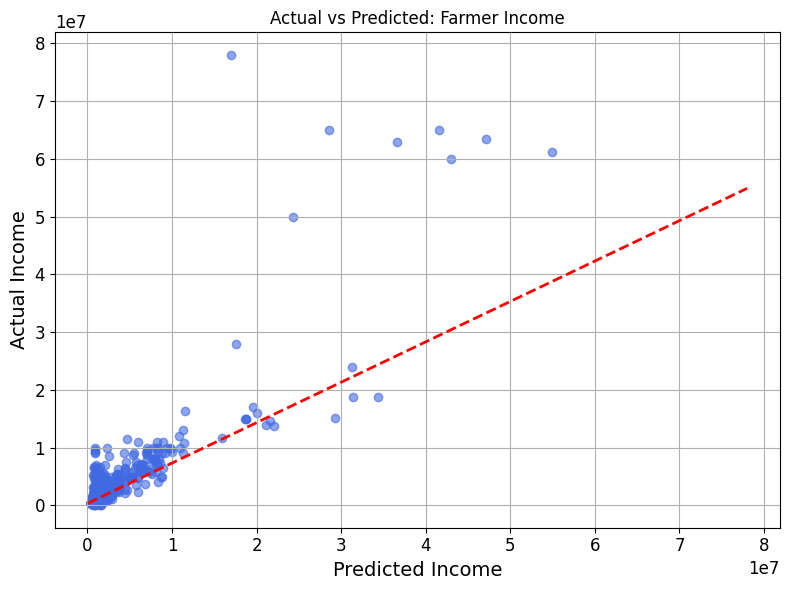

In [34]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_pred), np.expm1(y_val), alpha=0.6, color='royalblue')
plt.plot([np.expm1(y_val).min(), np.expm1(y_val).max()], [np.expm1(y_pred).min(), np.expm1(y_pred).max()], 'r--', lw=2)  # Ideal line
plt.ylabel('Actual Income')
plt.xlabel('Predicted Income')
plt.title('Actual vs Predicted: Farmer Income')
plt.grid(True)
plt.tight_layout()

save_fig("Actual vs Predicted Farmer Income plot_2")
plt.show()


Saving figure residual_plot_2


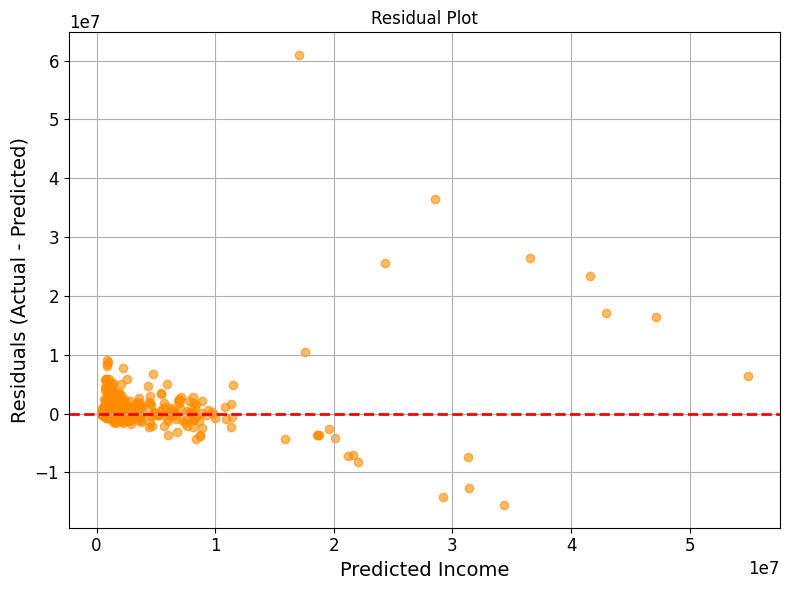

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals
residuals = np.expm1(y_val) - np.expm1(y_pred)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_pred), residuals, alpha=0.6, color='darkorange')
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Zero residual line
plt.xlabel('Predicted Income')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.tight_layout()

save_fig("residual_plot_2")
plt.show()


## Learning Curve (LoC)

Saving figure Learning Curve lgbm plot_2


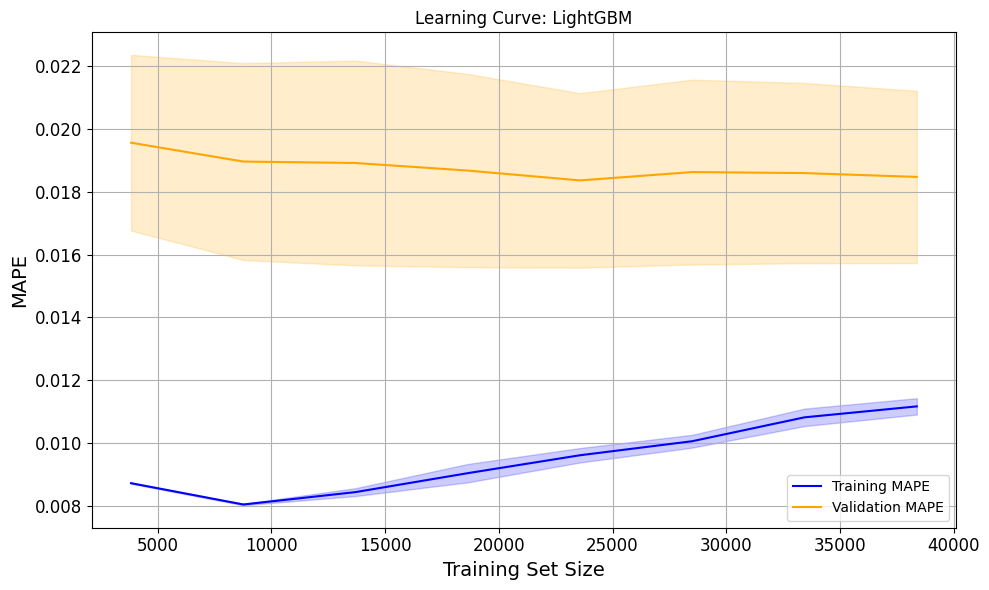

In [33]:
from sklearn.model_selection import learning_curve

# Get learning curve metrics
train_sizes, train_scores, test_scores = learning_curve(
    estimator=lgb_best_log,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1
)

# Convert negative MAPE to positive
train_scores = -train_scores
test_scores = -test_scores

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training MAPE', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, test_mean, label='Validation MAPE', color='orange')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='orange')

plt.xlabel("Training Set Size")
plt.ylabel("MAPE")
plt.title("Learning Curve: LightGBM")
plt.legend()
plt.grid(True)
plt.tight_layout()

save_fig("Learning Curve lgbm plot_2")
plt.show()